## Eradiate setup for simulation in spherical geometry

In [1]:
import eradiate
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from eradiate import scenes as ertsc
from eradiate import unit_registry as ureg

eradiate.set_mode("mono_polarized")
eradiate.plot.set_style()  # set plot style for eradiate


### Definition of a standard atmosphere

Specify standard atmosphere (e.g. tropical, midlatitude summer, midlatitude winter, subarctic summer, subarctic winter, US standard atmosphere 1976).

List all available identifiers with ```joseki.identifiers()```.

In [2]:
usstd=ertsc.atmosphere.MolecularAtmosphere(
    thermoprops={
        "identifier": "afgl_1986-us_standard",
        "z": np.linspace(0.0, 120.0, 121) * ureg.km,
    },
)

atmosphere = ertsc.atmosphere.HeterogeneousAtmosphere(
            molecular_atmosphere=usstd,
            #particle_layers=[particle_layer]
    )

### Define an AtmosphereExperiment

All is put together in a eradiate "experiment". In addition the surface (here Lambertian) and the sun position need to be inlcuded.

In [3]:
def run_exp(spp, geometry, atmosphere, origins, directions, integrator=None):
    """
    Run radiance simulation.
    """

    if integrator is None:
        integrator = ertsc.integrators.VolPathIntegrator()
    
    exp = eradiate.experiments.AtmosphereExperiment( 
        geometry=geometry,
        surface={
            "type": "lambertian",
            "reflectance": 0.0,
        },
        illumination={
            "type": "directional",
            "zenith": 85,
            "azimuth": 0,
            "irradiance": 1.0
        },
        
        atmosphere=atmosphere,
        
        measures=[
            ertsc.measure.MultiRadiancemeterMeasure(
                id="radiances",
                origins=origins,
                directions=directions,
                srf={"type": "multi_delta", "wavelengths": wavelength}
            )],
        integrator=integrator
    )

    exp.integrator.stokes = True
    exp.integrator.meridian_align = True

    return eradiate.run(exp, spp=spp)

In [4]:
wavelength = np.array([400]) * ureg.nm

vza = np.arange(0.,90.1, 1.)
vaa = np.arange(0.,180.1, 90.)
spp=100000

layout = eradiate.scenes.measure.GridLayout(
        zeniths=vza, azimuths=vaa,
    )


In [5]:
EARTH_RADIUS = eradiate.constants.EARTH_RADIUS

origins = np.zeros_like(layout.directions)+0.1
origins[:,2] += EARTH_RADIUS.m_as("m")

result_eradiate_sp = run_exp(spp=spp, geometry="spherical_shell", atmosphere=atmosphere, origins=origins, directions=layout.directions)


In [6]:

origins = np.zeros_like(layout.directions)+0.1
result_eradiate_pp = run_exp(spp=spp, geometry="plane_parallel", atmosphere=atmosphere, origins=origins, directions=layout.directions, integrator=ertsc.integrators.PiecewiseVolPathIntegrator())

NameError: name 'DoP_pp' is not defined

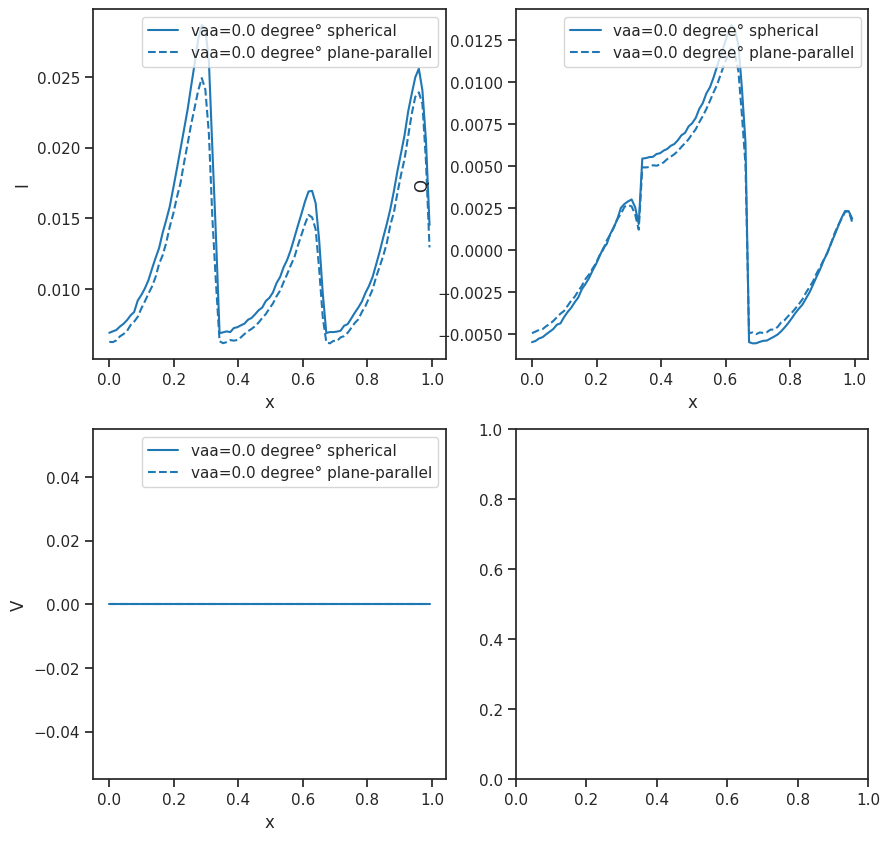

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
stokes_labels = ['I', 'Q', 'U', 'V']
colors = ['tab:blue', 'tab:orange', 'tab:green']
vaa = layout.azimuths

for idx_vaa, vaa_val in enumerate(vaa):
    # Select x_index for current vaa
    x_indices = np.arange(idx_vaa, len(vza)*len(vaa), len(vaa))
    x = result_eradiate_sp.x.values[x_indices]

    # Spherical geometry
    stokes_sp = result_eradiate_sp.radiance.sel(stokes=stokes_labels, saa=0, sza=85, w=400.0).isel(x_index=x_indices)
    # Plane parallel geometry
    stokes_pp = result_eradiate_pp.radiance.sel(stokes=stokes_labels, saa=0, sza=85, w=400.0).isel(x_index=x_indices)

    # Plot I, Q, V
    for i, stokes_name in enumerate(['I', 'Q', 'V']):
        y_sp = stokes_sp.sel(stokes=stokes_name).values
        y_pp = stokes_pp.sel(stokes=stokes_name).values
        if y_sp.shape[0] == 1:
            y_sp = y_sp[0]
        if y_pp.shape[0] == 1:
            y_pp = y_pp[0]
        axs[i].plot(x, y_sp, color=colors[idx_vaa], label=f'vaa={vaa_val}° spherical', linestyle='-')
        axs[i].plot(x, y_pp, color=colors[idx_vaa], label=f'vaa={vaa_val}° plane-parallel', linestyle='--')
        axs[i].set_ylabel(stokes_name)
        axs[i].set_xlabel('x')
        axs[i].legend()

    # Degree of Polarization (DoP)
    I_sp = stokes_sp.sel(stokes='I')
    Q_sp = stokes_sp.sel(stokes='Q')
    U_sp = stokes_sp.sel(stokes='U')
    V_sp = stokes_sp.sel(stokes='V')
    DoP_sp = np.sqrt(Q_sp**2 + U_sp**2 + V_sp**2) / I_sp

    if DoP_sp.shape[0] == 1:
        DoP_sp = DoP_sp.values[0]
    else:
        DoP_sp = DoP_sp.values
    if DoP_pp.shape[0] == 1:
        DoP_pp = DoP_pp.values[0]
    else:
        DoP_pp = DoP_pp.values
    axs[3].plot(x, DoP_sp, color=colors[idx_vaa], label=f'vaa={vaa_val}° spherical', linestyle='-')
    axs[3].plot(x, DoP_pp, color=colors[idx_vaa], label=f'vaa={vaa_val}° plane-parallel', linestyle='--')
    axs[3].set_ylabel('DoP')
    axs[3].set_xlabel('x')
    axs[3].legend()

    axs[3].plot(x, DoP_sp, color=colors[idx_vaa], label=f'vaa={vaa_val}° spherical', linestyle='-')
    axs[3].plot(x, DoP_pp, color=colors[idx_vaa], label=f'vaa={vaa_val}° plane-parallel', linestyle='--')
    axs[3].set_ylabel('DoP')
    axs[3].set_xlabel('x')
    axs[3].legend()

plt.tight_layout()
plt.show()